# Курсовой проект

**Основное**
- Дедлайн - 21 июня 23:59
- Целевая метрика precision@5. Порог для уcпешной сдачи проекта precision@5 > 25%
- Бейзлайн решения - [MainRecommender](https://github.com/geangohn/recsys-tutorial/blob/master/src/recommenders.py)
- Сдаем ссылку на github с решением. На github должен быть файл recommendations.csv (user_id | [rec_1, rec_2, ...] с рекомендациями. rec_i - реальные id item-ов (из retail_train.csv)

- Будет public тестовый датасет, на котором вы сможете измерять метрику
- Также будет private тестовый датасет для измерения финального качества
- НЕ обязательно, но крайне желательно использовать 2-ух уровневые рекоммендательные системы в проекте

**Hints:** 

Сначала просто попробуйте разные параметры MainRecommender:  
- N в топ-N товарах при формировании user-item матирцы (сейчас топ-5000)  
- Различные веса в user-item матрице (0/1, кол-во покупок, log(кол-во покупок + 1), сумма покупки, ...)  
- Разные взвешивания матрицы (TF-IDF, BM25 - у него есть параметры)  
- Разные смешивания рекомендаций (обратите внимание на бейзлайн - прошлые покупки юзера)  

Сделайте MVP - минимально рабочий продукт - (пусть даже top-popular), а потом его улучшайте

Если вы делаете двухуровневую модель - следите за валидацией 

## Библиотеки и загрузка данных

In [58]:
import sys

sys.path.append(sys.path[0] + '/src')
# print(sys.path)

In [59]:
import warnings
warnings.simplefilter(action='ignore')

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import os, sys

from lightgbm import LGBMClassifier

from metrics import precision_at_k, recall_at_k 
from utils import prefilter_items, split_train_val, prepare_users, prepare_items, unstack_user_item
from recommenders import RecommenderDataset, BaseRecommender, OwnRecommender, AlsRecommender, Level2Recommender

In [60]:
DATAROOT = 'data/'


In [61]:
data = pd.read_csv('data/retail_train.csv')
items = pd.read_csv('data/product.csv')
users = pd.read_csv('data/hh_demographic.csv')

# column processing
items.columns = [col.lower() for col in items.columns]
users.columns = [col.lower() for col in users.columns]

items.rename(columns={'product_id': 'item_id'}, inplace=True)
users.rename(columns={'household_key': 'user_id'}, inplace=True)

In [62]:
users = prepare_users(users)
users.head()

,marital_status_code,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_id,ageFrom,ageTo,incomeFrom,incomeTo
0,A,Homeowner,2 Adults No Kids,2.0,0.0,1,65.0,100.0,35.0,49.0
1,A,Homeowner,2 Adults No Kids,2.0,0.0,7,45.0,54.0,50.0,74.0
2,U,Unknown,2 Adults Kids,3.0,1.0,8,25.0,34.0,25.0,34.0
3,U,Homeowner,2 Adults Kids,4.0,2.0,13,25.0,34.0,75.0,99.0
4,B,Homeowner,Single Female,1.0,0.0,16,45.0,54.0,50.0,74.0


In [63]:
items = prepare_items(items)
items.head()

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION
2,26093,69,PASTRY,Private,BREAD,BREAD:ITALIAN/FRENCH
3,26190,69,GROCERY,Private,FRUIT - SHELF STABLE,APPLE SAUCE
4,26355,69,GROCERY,Private,COOKIES/CONES,SPECIALTY COOKIES


In [64]:
data.head()

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0


## Разбивка и обучение моделей

In [65]:
NUMBER_OF_FEATURES_LVL_1 = 500

In [66]:
# делим на train / validate1 / validate2
train, val1, val2 = split_train_val(data, 6, 3)

# фильтруем items от ненужного и берем только 5000 (+1 на остальное)
was = train.item_id.nunique()
train = prefilter_items(train)
print(f'Decreased amount of items from {was} to {train.item_id.nunique()}')

data_train_lvl_2 = val1.copy()  # Для наглядности. Далее мы добавим изменения, и они будут отличаться


Decreased amount of items from 83685 to 9523


### Расчет моделей первого уровня

In [67]:
ds = RecommenderDataset(train)

In [68]:
base = BaseRecommender(ds).fit()
own = OwnRecommender(ds).fit()
als = AlsRecommender(ds).fit()



100%|██████████| 15/15 [00:02<00:00,  6.29it/s]


In [69]:
def recommend(data, N=50):
    res = data.groupby('user_id')['item_id'].unique().reset_index()
    res.columns=['user_id', 'actual']

    res['recommend_base'] = base.recommend(res.user_id, N)
    res['recommend_own'] = own.recommend(res.user_id, N)
    res['recommend_als'] = als.recommend(res.user_id, N)
    res['recommend_als_similar_users'] = als.recommend(res.user_id, N, by='similarUsers')
    res['recommend_als_similar_items'] = als.recommend(res.user_id, N, by='similarItems')
    return res

In [70]:
result_lvl_1 = recommend(val1, NUMBER_OF_FEATURES_LVL_1)
result_lvl_1.head(2)

,user_id,actual,recommend_base,recommend_own,recommend_als,recommend_als_similar_users,recommend_als_similar_items
0,1,"[853529, 865456, 867607, 872137, 874905, 87524...","[856942, 9527290, 940947, 1074612, 5577022, 92...","[921345, 887225, 894439, 911411, 895478, 86376...","[921345, 901543, 918733, 886481, 1113588, 8448...","[856942, 1106523, 1133018, 951590, 908531, 840...","[13876352, 9526410, 1006414, 1106894, 8118726,..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870...","[8090521, 1133018, 5569230, 1106523, 916122, 1...","[840609, 926796, 821083, 927265, 919423, 90916...","[1005186, 970760, 1110843, 1104604, 1065593, 1...","[8090521, 1106523, 1133018, 951590, 908531, 84...","[1137346, 1106523, 7025275, 1133018, 985999, 8..."


In [71]:
result_train_lvl_1 = recommend(train, NUMBER_OF_FEATURES_LVL_1)
result_train_lvl_1.head(2)

,user_id,actual,recommend_base,recommend_own,recommend_als,recommend_als_similar_users,recommend_als_similar_items
0,1,"[825123, 831447, 840361, 845307, 852014, 99999...","[856942, 9527290, 940947, 1074612, 5577022, 92...","[921345, 887225, 894439, 911411, 895478, 86376...","[921345, 901543, 918733, 886481, 1113588, 8448...","[856942, 1106523, 1133018, 951590, 908531, 840...","[13876352, 9526410, 1006414, 1106894, 8118726,..."
1,2,"[854852, 930118, 1077555, 9999999, 5567388, 55...","[8090521, 1133018, 5569230, 1106523, 916122, 1...","[840609, 926796, 821083, 927265, 919423, 90916...","[1005186, 970760, 1110843, 1104604, 1065593, 1...","[8090521, 1106523, 1133018, 951590, 908531, 84...","[1137346, 1106523, 7025275, 1133018, 985999, 8..."


In [72]:
result_lvl_1.apply(lambda row: recall_at_k(row['recommend_own'], row['actual'], 50), axis=1).mean()

0.0138633738748979

In [73]:
result_lvl_1.apply(lambda row: recall_at_k(row['recommend_base'], row['actual'], 50), axis=1).mean()

0.1351892595461908

In [74]:
result_lvl_1.apply(lambda row: recall_at_k(row['recommend_als'], row['actual'], 50), axis=1).mean()

0.01998885245269536

In [75]:
result_lvl_1.apply(lambda row: recall_at_k(row['recommend_als_similar_users'], row['actual'], 50), axis=1).mean()

0.06980965979350147

In [76]:
result_lvl_1.apply(lambda row: recall_at_k(row['recommend_als_similar_items'], row['actual'], 50), axis=1).mean()

0.04167259614112276

In [77]:
result_lvl_1.head(2)

,user_id,actual,recommend_base,recommend_own,recommend_als,recommend_als_similar_users,recommend_als_similar_items
0,1,"[853529, 865456, 867607, 872137, 874905, 87524...","[856942, 9527290, 940947, 1074612, 5577022, 92...","[921345, 887225, 894439, 911411, 895478, 86376...","[921345, 901543, 918733, 886481, 1113588, 8448...","[856942, 1106523, 1133018, 951590, 908531, 840...","[13876352, 9526410, 1006414, 1106894, 8118726,..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870...","[8090521, 1133018, 5569230, 1106523, 916122, 1...","[840609, 926796, 821083, 927265, 919423, 90916...","[1005186, 970760, 1110843, 1104604, 1065593, 1...","[8090521, 1106523, 1133018, 951590, 908531, 84...","[1137346, 1106523, 7025275, 1133018, 985999, 8..."


In [78]:
n = [i for i in range(10,501, 20)]
col_names = [
    ('recommend_own', own, False ),
    ('recommend_base', base, False),
    ('recommend_als', als, False),
    ('recommend_als_similar_users', als, 'similarUsers'),
    ('recommend_als_similar_items', als, 'similarIsers'),
    ]
rec_dict = {}


for column, model, simular in col_names:
    rec_dict[column] = []
    for i in n:
        rec_dict[column].append(result_lvl_1.apply(lambda row: recall_at_k(row[column], row['actual'], i), axis=1).mean())
   

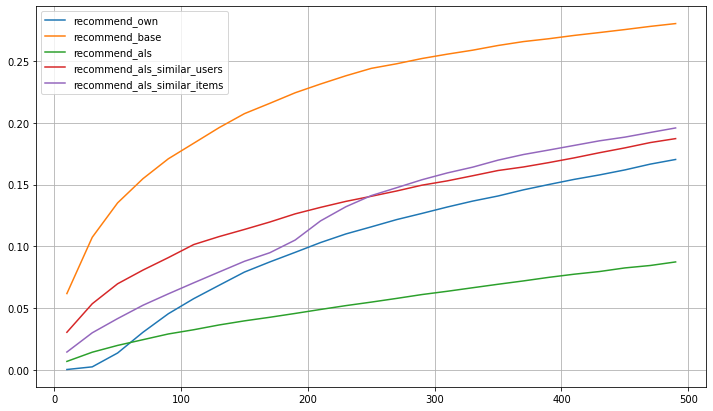

In [79]:
plt.figure(figsize=(12, 7))
legend_list = []
for i in rec_dict:    
    plt.plot(n, rec_dict[i]) #, 'o-r', alpha=0.7, label=i, lw=5, mec='b', mew=2, ms=10)
    legend_list.append(i)
plt.legend(legend_list, loc=2)
plt.grid(True);

### Расчет моделей второго уровня

In [80]:
new_items = items.merge(data, on='item_id', how='left')

    
price = new_items.groupby('item_id')['sales_value'].sum() / new_items.groupby('item_id')['quantity'].sum()
price = price.groupby('item_id').mean().reset_index()
price.columns = ['item_id', 'price']

In [81]:
def new_user_features(data, user_features):
    '''
    Добавляет среднюю корзину и средний чек за неделю.
    '''
    
    new_user_features = user_features.merge(data, on='user_id', how='left')

    
    basket = new_user_features.groupby(['user_id'])['sales_value'].sum().reset_index()
    baskets_qnt = new_user_features.groupby('user_id')['basket_id'].count().reset_index()
    baskets_qnt.rename(columns={'basket_id': 'baskets_qnt'}, inplace=True)
    average_basket = basket.merge(baskets_qnt)
    average_basket['average_basket'] = average_basket.sales_value / average_basket.baskets_qnt
    average_basket['sum_per_week'] = average_basket.sales_value / new_user_features.week_no.nunique()
    average_basket = average_basket.drop(['sales_value', 'baskets_qnt'], axis=1)
    user_features = user_features.merge(average_basket)
    
    

    return user_features

In [82]:
def new_item_features(data, item_features):
    
    '''
    Считает цену, количество продаж и продаваемость за неделю.
    '''
    
    new_item_features = item_features.merge(data, on='item_id', how='left')
    
   
    price = new_item_features.groupby('item_id')['sales_value'].sum() / new_item_features.groupby('item_id')['quantity'].sum()
    price = price.groupby('item_id').mean().reset_index()
    price.columns = ['item_id', 'price']
    price['price'].fillna(0, inplace= True)
    
    item_qnt = new_item_features.groupby(['item_id'])['quantity'].count().reset_index()
    item_qnt.rename(columns={'quantity': 'quantity_of_sales'}, inplace=True)
    item_qnt['quantity_of_sales_per_week'] = item_qnt['quantity_of_sales'] / new_item_features['week_no'].nunique()
    
    item_features = item_features.merge(item_qnt, on='item_id')
    item_features = item_features.merge(price, on='item_id')
    item_features = item_features[item_features['quantity_of_sales']>0]
    
    return item_features

In [83]:
item_features = new_item_features(data_train_lvl_2, items)
item_features.head(2)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,quantity_of_sales,quantity_of_sales_per_week,price
60,28116,69,GROCERY,Private,DRY MIX DESSERTS,GELATIN,1,0.166667,0.33
61,28117,69,GROCERY,Private,DRY MIX DESSERTS,GELATIN,1,0.166667,0.34


In [84]:
user_features = new_user_features(data_train_lvl_2, users)
user_features.head()

,marital_status_code,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_id,ageFrom,ageTo,incomeFrom,incomeTo,average_basket,sum_per_week
0,A,Homeowner,2 Adults No Kids,2.0,0.0,1,65.0,100.0,35.0,49.0,2.569774,56.963333
1,A,Homeowner,2 Adults No Kids,2.0,0.0,7,45.0,54.0,50.0,74.0,2.085000,31.275000
2,U,Unknown,2 Adults Kids,3.0,1.0,8,25.0,34.0,25.0,34.0,2.472683,50.690000
3,U,Homeowner,2 Adults Kids,4.0,2.0,13,25.0,34.0,75.0,99.0,6.248079,184.318333
4,B,Homeowner,Single Female,1.0,0.0,16,45.0,54.0,50.0,74.0,3.435714,4.008333


In [85]:
def train_test_preprocessing(data):    
    users_lvl_2 = pd.DataFrame(data['user_id'].unique())
    users_lvl_2.columns = ['user_id']

    train_users = train['user_id'].unique()
    train_users.shape

    users_lvl_2 = users_lvl_2[users_lvl_2['user_id'].isin(train_users)]
    users_lvl_2_ = users_lvl_2.copy()
    # users_lvl_2['candidates'] = users_lvl_2['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=50))
    users_lvl_2['candidates'] = base.recommend(users_lvl_2.user_id, 20)


    items_emb = als.items_embedings()
    users_emb = als.users_embedings()
    
    s = users_lvl_2.apply(lambda x: pd.Series(x['candidates']), axis=1).stack().reset_index(level=1, drop=True)
    s.name = 'item_id'

    users_lvl_2 = users_lvl_2.drop('candidates', axis=1).join(s)
    
    users_lvl_2['flag'] = 1

    targets_lvl_2 = data[['user_id', 'item_id']].copy()
    targets_lvl_2.head(2)

    targets_lvl_2['target'] = 1  

    targets_lvl_2 = users_lvl_2.merge(targets_lvl_2, on=['user_id', 'item_id'], how='left')

    targets_lvl_2['target'].fillna(0, inplace= True)
    targets_lvl_2.drop('flag', axis=1, inplace=True)

    targets_lvl_2 = targets_lvl_2.merge(item_features, on='item_id', how='left')
    targets_lvl_2 = targets_lvl_2.merge(user_features, on='user_id', how='left')

    targets_lvl_2 = targets_lvl_2.merge(users_emb, on='user_id', how='left')
    targets_lvl_2 = targets_lvl_2.merge(items_emb, on='item_id', how='left')

    # X = targets_lvl_2.drop('target', axis=1)
    # y = targets_lvl_2[['target']]
    
    return targets_lvl_2#X, y

In [86]:

data_lvl_2 = train_test_preprocessing(data_train_lvl_2)

# users_lvl_2.merge(users_emb, on='user_id', how='left')

In [87]:
data_lvl_2.shape


(50441, 62)

In [90]:
data_lvl_2.head()

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,quantity_of_sales,quantity_of_sales_per_week,...,itm10,itm11,itm12,itm13,itm14,itm15,itm16,itm17,itm18,itm19
0,2070,1085604,1.0,103,GROCERY,National,SOFT DRINKS,SFT DRNK SNGL SRV BTL CARB (EX,156.0,26.000000,...,-0.006656,0.013549,0.006651,0.004686,-0.007351,0.004111,0.005529,0.011151,0.002821,0.038298
1,2070,834103,1.0,2224,GROCERY,National,SOFT DRINKS,SFT DRNK SNGL SRV BTL CARB (EX,58.0,9.666667,...,-0.004560,0.009263,0.005076,0.000015,-0.003433,-0.000106,0.015005,0.010084,-0.000182,0.039913
2,2070,834103,1.0,2224,GROCERY,National,SOFT DRINKS,SFT DRNK SNGL SRV BTL CARB (EX,58.0,9.666667,...,-0.004560,0.009263,0.005076,0.000015,-0.003433,-0.000106,0.015005,0.010084,-0.000182,0.039913
3,2070,834103,1.0,2224,GROCERY,National,SOFT DRINKS,SFT DRNK SNGL SRV BTL CARB (EX,58.0,9.666667,...,-0.004560,0.009263,0.005076,0.000015,-0.003433,-0.000106,0.015005,0.010084,-0.000182,0.039913
4,2070,834103,1.0,2224,GROCERY,National,SOFT DRINKS,SFT DRNK SNGL SRV BTL CARB (EX,58.0,9.666667,...,-0.004560,0.009263,0.005076,0.000015,-0.003433,-0.000106,0.015005,0.010084,-0.000182,0.039913


In [88]:
# X_train, y_train = train_test_preprocessing(data_train_lvl_2)
data_lvl_2 = train_test_preprocessing(data_train_lvl_2)

data_test_lvl_2 = train_test_preprocessing(val2)


In [93]:
X_train = data_lvl_2.drop('target', axis=1)
y_train = data_lvl_2[['target']]

X_test = data_test_lvl_2.drop('target', axis=1)
y_test = data_test_lvl_2[['target']]

In [94]:
cat_feats = X_train.columns[2:].tolist()

In [95]:
X_train[cat_feats] = X_train[cat_feats].astype('category')
# X_test, y_test = train_test_preprocessing(val2)
X_test[cat_feats] = X_test[cat_feats].astype('category')

In [101]:
lgb = LGBMClassifier(objective='binary', max_depth=10, categorical_column=cat_feats)
lgb.fit(X_train, y_train)



LGBMClassifier(categorical_column=['manufacturer', 'department', 'brand',
                                   'commodity_desc', 'sub_commodity_desc',
                                   'quantity_of_sales',
                                   'quantity_of_sales_per_week', 'price',
                                   'marital_status_code', 'homeowner_desc',
                                   'hh_comp_desc', 'household_size_desc',
                                   'kid_category_desc', 'ageFrom', 'ageTo',
                                   'incomeFrom', 'incomeTo', 'average_basket',
                                   'sum_per_week', 'usr0', 'usr1', 'usr2',
                                   'usr3', 'usr4', 'usr5', 'usr6', 'usr7',
                                   'usr8', 'usr9', 'usr10', ...],
               max_depth=10, objective='binary')

In [102]:
test_preds_proba = lgb.predict_proba(X_test)[:, 1]
test_preds_proba[:10]

ValueError: Number of features of the model must match the input. Model n_features_ is 61 and input n_features is 62 

In [ ]:
def get_final_recomendation(X_test, test_preds_proba, data_val_lvl_2):
    X_test['predict_proba'] = test_preds_proba

    X_test.sort_values(['user_id', 'predict_proba'], ascending=False, inplace=True)

    result = X_test.groupby('user_id').head(5)

    recs = result.groupby('user_id')['item_id']
    recomendations = []
    for user, preds in recs:
        recomendations.append({'user_id': user, 'recomendations': preds.tolist()})

    recomendations = pd.DataFrame(recomendations)

    result_lvl_2 = data_val_lvl_2.groupby('user_id')['item_id'].unique().reset_index()
    result_lvl_2.columns=['user_id', 'actual']

    result_lvl_2 = result_lvl_2.merge(recomendations)
    
    return result_lvl_2

In [ ]:
result_lvl_2 = get_final_recomendation(X_test, test_preds_proba, val2)

In [103]:
result_lvl_2.apply(lambda row: precision_at_k(row['recomendations'], row['actual']), axis=1).mean()

0.24301812836844364

In [104]:
from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.tasks import Task
from lightautoml.tasks.common_metric import mean_quantile_error

In [105]:
train_data = data_lvl_2
train_data.head()

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,quantity_of_sales,quantity_of_sales_per_week,...,itm10,itm11,itm12,itm13,itm14,itm15,itm16,itm17,itm18,itm19
0,2070,1085604,1.0,103,GROCERY,National,SOFT DRINKS,SFT DRNK SNGL SRV BTL CARB (EX,156.0,26.000000,...,-0.006656,0.013549,0.006651,0.004686,-0.007351,0.004111,0.005529,0.011151,0.002821,0.038298
1,2070,834103,1.0,2224,GROCERY,National,SOFT DRINKS,SFT DRNK SNGL SRV BTL CARB (EX,58.0,9.666667,...,-0.004560,0.009263,0.005076,0.000015,-0.003433,-0.000106,0.015005,0.010084,-0.000182,0.039913
2,2070,834103,1.0,2224,GROCERY,National,SOFT DRINKS,SFT DRNK SNGL SRV BTL CARB (EX,58.0,9.666667,...,-0.004560,0.009263,0.005076,0.000015,-0.003433,-0.000106,0.015005,0.010084,-0.000182,0.039913
3,2070,834103,1.0,2224,GROCERY,National,SOFT DRINKS,SFT DRNK SNGL SRV BTL CARB (EX,58.0,9.666667,...,-0.004560,0.009263,0.005076,0.000015,-0.003433,-0.000106,0.015005,0.010084,-0.000182,0.039913
4,2070,834103,1.0,2224,GROCERY,National,SOFT DRINKS,SFT DRNK SNGL SRV BTL CARB (EX,58.0,9.666667,...,-0.004560,0.009263,0.005076,0.000015,-0.003433,-0.000106,0.015005,0.010084,-0.000182,0.039913


In [107]:
TASK = Task('reg', loss='mse', metric=mean_quantile_error, greater_is_better=False)
TIMEOUT = 300000
N_THREADS = 3
N_FOLDS = 5
RANDOM_STATE = 42
TARGET_NAME = 'target'
TEST_SIZE=0.2

In [108]:
roles = {'target': TARGET_NAME, 'drop': ['user_id', 'item_id']}

In [109]:
# automl_model = TabularAutoML(task=TASK,
#                             timeout=TIMEOUT,
#                             cpu_limit = N_THREADS,
#                             gpu_ids='all',
#                             reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE},
                             
#                             general_params={'use_algos': [ ['lgb_tuned', 'cb_tuned', 'cb', 'lgb'], ['lgb_tuned', 'cb'] ]},
                             
#                             tuning_params={'max_tuning_iter': 10},
# )

automl_model = TabularAutoML(task=TASK,
                            timeout=TIMEOUT,
                            cpu_limit = N_THREADS,
                            gpu_ids='all',
                            reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE},
                             
                            general_params={'use_algos': [ ['lgb_tuned',  'lgb'], ['lgb_tuned'] ]},
                             
                            tuning_params={'max_tuning_iter': 10},
)

In [110]:
oof_pred = automl_model.fit_predict(train_data, roles = roles)


INFO:lightautoml.automl.presets.base:Stdout logging level is ERROR.
INFO:lightautoml.automl.presets.base:Task: reg

INFO:lightautoml.automl.presets.base:Start automl preset with listed constraints:
INFO:lightautoml.automl.presets.base:- time: 300000.00 seconds
INFO:lightautoml.automl.presets.base:- CPU: 3 cores
INFO:lightautoml.automl.presets.base:- memory: 16 GB

INFO:lightautoml.reader.base:Train data shape: (50441, 62)

INFO3:lightautoml.reader.base:Feats was rejected during automatic roles guess: []
INFO:lightautoml.automl.base:Layer 1 train process start. Time left 299982.69 secs
INFO3:lightautoml.ml_algo.boost_lgbm:[1]	valid's l2: 0.228387	valid's Opt metric: 0.222389
INFO3:lightautoml.ml_algo.boost_lgbm:Training until validation scores don't improve for 200 rounds
DEBUG:lightautoml.ml_algo.boost_lgbm:[2]	valid's l2: 0.225138	valid's Opt metric: 0.220801
DEBUG:lightautoml.ml_algo.boost_lgbm:[3]	valid's l2: 0.222038	valid's Opt metric: 0.219223
DEBUG:lightautoml.ml_algo.boost_lgbm

KeyboardInterrupt: 


---- Качество на TRAIN-e ----

 >> Level1 Precision@5:


TypeError: precision_at_k() missing 1 required positional argument: 'bought_list'

## Сохранение модели

In [ ]:
def save(data, field, file):
    tmp = data[['user_id', field]].copy()
    tmp.columns = ['user_id', 'result']
    tmp['result'] = tmp.result.apply(lambda x: list(x)[:5])
    tmp.to_csv(f'{file}.csv')
    tmp.to_pickle(f'{file}.pkl')

    
# сохраним предсазания модели первого уровня
save(main, 'recommend_main', 'level1')

# сохраним предсазания модели второго уровня
save(main, 'recommend_level2', 'recommendations')